In [10]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_training import FCNImitationDataset, FCNNodeFakeDataset, FCNImitationPolicy, FCNNodeSelectionPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()
loss_func = nn.MSELoss()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
#             print(batch[0], batch[1])
#             print(target.sum())
            batch = batch.to(DEVICE)
            target = target.squeeze().to(DEVICE)*1

            out = policy(batch).squeeze()
            print(target.shape, out.shape)
            loss = loss_func(out, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            mean_loss += loss.item() * batch.shape[0]
            n_samples_processed += batch.shape[0]

    mean_loss /= n_samples_processed
    return mean_loss


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output



positive_sample_files = [str(path) for path in Path('data/1_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
positive_trains = positive_sample_files[:int(0.8*len(positive_sample_files))]
positive_valids = positive_sample_files[int(0.8*len(positive_sample_files)):]

negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
negative_valids = negative_sample_files[int(0.8*len(negative_sample_files)):]

random.shuffle(negative_trains)
negative_trains = negative_trains[:len(positive_trains)]

random.shuffle(negative_valids)
negative_valids = negative_valids[:len(positive_valids)]


train_files = positive_trains + negative_trains
valid_files = positive_valids + negative_valids

random.shuffle(train_files)

# positive_sample_files1 = [str(path) for path in Path('data/1_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
# # positive_sample_files2 = [str(path) for path in Path('positive_node_samples3/').glob('sample_*.pkl')]
# positive_sample_files = positive_sample_files1
# random.shuffle(positive_sample_files)
# positive_sample_files = positive_sample_files[:100000]
# print('files loaded')

# sample_indices = random.sample(range(1, 4165605), 100000)
# negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
# # negative_sample_files = [str(path) for path in Path('data/10k_negative_node_samples/').glob('sample_*.pkl')]
# print(len(negative_sample_files))
# imbalance_ratio = len(negative_sample_files)/len(positive_sample_files)

# random.shuffle(negative_sample_files)
# print(len(positive_sample_files), len(negative_sample_files))
# negative_sample_files = negative_sample_files[:len(positive_sample_files)]
# sample_files = positive_sample_files + negative_sample_files
# random.shuffle(sample_files)

# valid_sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
# random.shuffle(valid_sample_files)
# valid_sample_files = valid_sample_files[:2000]

# train_files = sample_files[:int(0.8*len(sample_files))]
# valid_files = sample_files[int(0.8*len(sample_files)):]

train_data = FCNImitationDataset(train_files)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = FCNImitationDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

policy = FCNImitationPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
trains = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss}" )
    trains.append(train_loss)
    
    valid_loss = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss}" )
    valids.append(valid_loss)
    
torch.save(policy.state_dict(), 'trained_params_imitation2.pkl')

Epoch 1


  0%|          | 3/2280 [00:00<01:29, 25.31it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  0%|          | 8/2280 [00:00<01:00, 37.54it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  1%|          | 13/2280 [00:00<00:54, 41.22it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  1%|          | 18/2280 [00:00<00:53, 42.21it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  1%|          | 23/2280 [00:00<00:52, 43.05it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  1%|          | 28/2280 [00:00<00:51, 43.43it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  1%|▏         | 33/2280 [00:00<00:51, 43.49it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  2%|▏         | 43/2280 [00:01<00:50, 43.91it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  2%|▏         | 48/2280 [00:01<00:51, 43.59it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  2%|▏         | 53/2280 [00:01<00:50, 43.72it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  3%|▎         | 58/2280 [00:01<00:50, 43.98it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  3%|▎         | 63/2280 [00:01<00:50, 43.70it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  3%|▎         | 68/2280 [00:01<00:50, 43.57it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  3%|▎         | 73/2280 [00:01<00:50, 43.97it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  3%|▎         | 78/2280 [00:01<00:50, 43.52it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  4%|▍         | 88/2280 [00:02<00:49, 44.46it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  4%|▍         | 98/2280 [00:02<00:49, 44.20it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  5%|▍         | 103/2280 [00:02<00:49, 44.07it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  5%|▍         | 108/2280 [00:02<00:49, 44.19it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  5%|▍         | 113/2280 [00:02<00:48, 44.34it/s]

torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8]) torch.Size([128, 8])


  5%|▌         | 117/2280 [00:02<00:50, 43.22it/s]

torch.Size([128, 8]) torch.Size([128, 8])


KeyboardInterrupt: 

In [11]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_training import FCNImitationDataset, FCNNodeFakeDataset, FCNImitationPolicy, FCNNodeSelectionPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader

LEARNING_RATE = 0.001
NB_EPOCHS = 150
PATIENCE = 10
EARLY_STOPPING = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sig = nn.Sigmoid()
loss_func = nn.MSELoss()

def process(policy, data_loader, optimizer=None):
    """
    This function will process a whole epoch of training or validation, depending on whether an optimizer is provided.
    """
    mean_loss = 0
    mean_acc = 0

    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    with torch.set_grad_enabled(optimizer is not None):
        for batch_data in tqdm(data_loader):
            batch, target = batch_data
#             print(batch[0], batch[1])
#             print(target.sum())
            batch = batch.to(DEVICE)
            target = target.squeeze().to(DEVICE)*1
            
            logits = policy(batch.antenna_features, batch.edge_index, batch.edge_attr, batch.variable_features)            
            print('shape', logits.shape)
            out = logits.reshape([batch.num_graphs, -1])
            
            out = policy(batch).squeeze()
            
            loss = loss_func(out, target.to(torch.float))
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            mean_loss += loss.item() * batch.shape[0]
            n_samples_processed += batch.shape[0]

    mean_loss /= n_samples_processed
    return mean_loss


def pad_tensor(input_, pad_sizes, pad_value=-1e8):
    """
    This utility function splits a tensor and pads each split to make them all the same size, then stacks them.
    """
    max_pad_size = pad_sizes.max()
    output = input_.split(pad_sizes.cpu().numpy().tolist())
    output = torch.stack([F.pad(slice_, (0, max_pad_size-slice_.size(0)), 'constant', pad_value)
                          for slice_ in output], dim=0)
    return output



positive_sample_files = [str(path) for path in Path('data/1_gnn_10k_positive_node_samples/').glob('sample_*.pkl')]
positive_trains = positive_sample_files[:int(0.8*len(positive_sample_files))]
positive_valids = positive_sample_files[int(0.8*len(positive_sample_files)):]

negative_sample_files = ['data/1_gnn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
negative_trains = negative_sample_files[:int(0.8*len(negative_sample_files))]
negative_valids = negative_sample_files[int(0.8*len(negative_sample_files)):]

random.shuffle(negative_trains)
negative_trains = negative_trains[:len(positive_trains)]

random.shuffle(negative_valids)
negative_valids = negative_valids[:len(positive_valids)]


train_files = positive_trains + negative_trains
valid_files = positive_valids + negative_valids

random.shuffle(train_files)

# positive_sample_files1 = [str(path) for path in Path('data/1_fcn_10k_positive_node_samples/').glob('sample_*.pkl')]
# # positive_sample_files2 = [str(path) for path in Path('positive_node_samples3/').glob('sample_*.pkl')]
# positive_sample_files = positive_sample_files1
# random.shuffle(positive_sample_files)
# positive_sample_files = positive_sample_files[:100000]
# print('files loaded')

# sample_indices = random.sample(range(1, 4165605), 100000)
# negative_sample_files = ['data/1_fcn_10k_negative_node_samples/sample_'+str(i)+'.pkl' for i in sample_indices]
# # negative_sample_files = [str(path) for path in Path('data/10k_negative_node_samples/').glob('sample_*.pkl')]
# print(len(negative_sample_files))
# imbalance_ratio = len(negative_sample_files)/len(positive_sample_files)

# random.shuffle(negative_sample_files)
# print(len(positive_sample_files), len(negative_sample_files))
# negative_sample_files = negative_sample_files[:len(positive_sample_files)]
# sample_files = positive_sample_files + negative_sample_files
# random.shuffle(sample_files)

# valid_sample_files = [str(path) for path in Path('node_samples/').glob('sample_*.pkl')]
# random.shuffle(valid_sample_files)
# valid_sample_files = valid_sample_files[:2000]

# train_files = sample_files[:int(0.8*len(sample_files))]
# valid_files = sample_files[int(0.8*len(sample_files)):]

train_data = FCNImitationDataset(train_files)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_data = FCNImitationDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

policy = FCNImitationPolicy().to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE)

valids = []
trains = []
for epoch in range(NB_EPOCHS):
    print(f"Epoch {epoch+1}")
    
    train_loss = process(policy, train_loader, optimizer)
    print(f"Train loss: {train_loss}" )
    trains.append(train_loss)
    
    valid_loss = process(policy, valid_loader, None)
    print(f"Valid loss: {valid_loss}" )
    valids.append(valid_loss)
    
torch.save(policy.state_dict(), 'trained_params_imitation2.pkl')

Epoch 1


  0%|          | 0/2280 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'antenna_features'

Text(0, 0.5, 'F1-score')

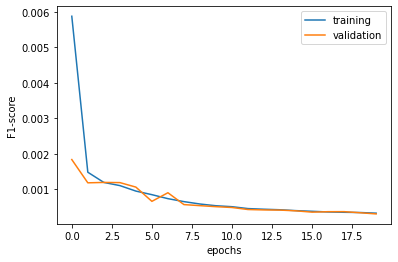

In [7]:
import matplotlib.pyplot as plt

plt.plot(trains)
plt.plot(valids)
plt.legend(['training', 'validation'])
plt.xlabel('epochs')
plt.ylabel('F1-score')

In [9]:
list(range(100,-1,-1))

[100,
 99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]

In [2]:
import torch
import torch.nn.functional as F
import torch_geometric
from fcn_training import FCNNodeDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import math 
from torch.utils.data import DataLoader
import numpy as np

from  acr_bb import Observation, ACRBBenv, DefaultBranchingPolicy, RandomPolicy, LinearObservation
from fcn_training import FCNDataset, FCNBranchingPolicy, FCNNodeSelectionPolicy 

MAX_SAMPLES = 100000

N = 8 # antennas
M = 4 # users
expert_prob = 0.5

def instance_generator(M, N):
    while 1:
        yield np.random.randn(2,N,M)

# instances = np.random.randn(MAX_SAMPLES, 2, N, M)
instances = instance_generator(M,N)

env = ACRBBenv(observation_function=LinearObservation)

obs, _,_,_,_  = env.reset(next(instances))

In [3]:
obs, _,_,_,_ = env.step(2)
a = obs.observation[24:28] + 1j*obs.observation[28:32]
angle = np.angle(a) 
angle[angle<0] += 2*np.pi

lb = obs.observation[24+3*8*4+2:126]
ub = obs.observation[126:130]
if np.random.rand(1)>0.3:
    mid = lb + np.random.rand(4)*(ub-lb)
    r = 1
    comp = np.exp(1j*mid)
    print('here')
else:
    mid = np.random.rand(4)*2*np.pi
    r = 1
    comp = np.exp(1j*mid)
if sum(mid<ub)+sum(mid>lb) == 8:
    label = 1
else:
    label = 0

print(mid)
print(lb)
print(ub)

lower bounds 0.056979456281294756 0.05665037712236675
[3.05164062e+00 1.51764131e-03 1.74864162e+00 4.88510349e+00]
[ 1.68609096 -0.20467164 -0.16533155  0.28578829]
[ 1.6466605   1.6342108  -0.17111205  0.07740174]


In [10]:
np.angle(env.active_node.w_feas)

array([[-0.22273167],
       [-1.66305339],
       [ 1.953208  ],
       [-0.87037179],
       [ 3.11667517],
       [ 1.41480285],
       [-1.12713787],
       [ 1.91449468]])

In [11]:
obs.observation[56:]

array([ 6.06045364e+00,  4.62013191e+00,  1.95320800e+00,  5.41281352e+00,
        3.11667517e+00,  1.41480285e+00,  5.15604744e+00,  1.91449468e+00,
        2.02044387e+00, -6.81960954e-01, -3.26736169e-01,  1.87059315e+00,
       -2.66508038e+00,  7.64409212e-01,  7.70503458e-01, -4.24004736e-01,
       -1.79267862e-01, -7.41319619e+00,  3.02809333e-01, -2.19216313e+00,
        2.11666711e-02,  3.61835452e+00, -1.99892644e+00,  7.04557354e-01,
        2.02838123e+00,  7.44449787e+00,  4.45477290e-01,  2.88178728e+00,
        2.66516444e+00,  3.69821726e+00,  2.14228441e+00,  8.22302305e-01,
        6.19469008e+00,  4.62065433e+00,  2.39418273e+00,  5.41880112e+00,
        3.13365059e+00,  1.36259881e+00,  5.08029719e+00,  2.11254051e+00,
        7.55496788e-01, -1.52880482e+00, -9.22801121e-01, -2.04321474e+00,
       -3.00115125e-01, -1.32413209e+00, -4.68237393e-01,  1.36467412e-01,
       -9.19116458e-02, -2.50762803e-01,  1.02174074e+00, -7.50697854e-02,
        8.14844331e-01,  

In [207]:
import torch

torch.cat((torch.tensor(np.real(mid)), torch.tensor(np.imag(mid)), torch.tensor(np.abs(mid)), torch.tensor(obs.observation))).shape

torch.Size([158])

In [85]:
a = np.random.rand(4)*2*np.pi
b = np.random.rand(4)*2*np.pi
c = np.random.rand(4)*2*np.pi



In [86]:
sum(c< a)

3

In [76]:
b<c

array([False, False, False,  True])

In [66]:
comp

array([-1.+1.2246468e-16j, -1.+1.2246468e-16j, -1.+1.2246468e-16j,
       -1.+1.2246468e-16j])

In [67]:
lb

array([0., 0., 0., 0.])

In [68]:
ub

array([6.28318531, 6.28318531, 6.28318531, 6.28318531])

In [59]:
a = 3*np.pi/2 + np.pi/4

In [60]:
a

5.497787143782138

In [62]:
b = 1*np.exp(1j*a)

In [64]:
np.angle(b)+2*np.pi

5.497787143782138

In [53]:
np.random.rand(1)> 0.5

array([ True])

In [28]:
angle

array([0.14602925, 3.63327729, 1.08245673, 1.55202076])

array([ 1.90497712+0.28017676j, -2.52041463-1.34981818j,
        1.24287801+2.33950317j,  0.02418395+1.28790262j])

In [16]:
obs

In [14]:
env.observation

AttributeError: 'ACRBBenv' object has no attribute 'observation'

In [12]:
env.

In [ ]:
policy = FCNNodeSelectionPolicy()



In [ ]:
a = torch.randn(())

In [4]:
a, b = train_data[0]

In [5]:
a.shape

torch.Size([146])

In [6]:
b.shape

torch.Size([])

In [21]:
import gzip
import pickle

with gzip.open('fcn_negative_node_samples/sample_10.pkl','rb') as f:
    sample = pickle.load(f)

In [7]:
import numpy as np

np.linalg.norm(np.random.randn(5,1),'fro')**2

3.3041506361597035

In [10]:
2*np.pi + np.angle([1-1j])

array([5.49778714])